In [1]:
!pip install tensorflow keras numpy opencv-python matplotlib librosa scikit-learn

In [15]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model, Sequential
import numpy as np
import librosa.display
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, multiply
from os import listdir
import cv2

# from keras.objectives import binary_crossentropy

# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

import os

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [19]:
def wav2mfcc(file_path, max_pad_len=100):
    wave, sr = librosa.load(file_path, mono=True, sr=44100)
    mfcc = librosa.feature.mfcc(y=wave, sr=sr, n_mfcc=13, n_fft=512)

    mfcc_normalized = (mfcc - np.min(mfcc)) / (np.max(mfcc) - np.min(mfcc))
    
    # If MFCC is longer than max_pad_len, truncate it
    if mfcc_normalized.shape[1] > max_pad_len:
        mfcc_normalized = mfcc_normalized[:, :max_pad_len]
    # If MFCC is shorter than max_pad_len, pad it
    else:
        pad_width = max_pad_len - mfcc_normalized.shape[1]
        mfcc_normalized = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    
    return mfcc_normalized

def augment_mfcc(mfcc):
    # Time stretching
    factor = np.random.uniform(0.8, 1.2)
    mfcc_stretched = librosa.effects.time_stretch(mfcc.T, rate=factor).T
    
    # Pitch shifting
    n_steps = np.random.randint(-2, 3)
    mfcc_shifted = librosa.effects.pitch_shift(mfcc.T, sr=22050, n_steps=n_steps).T
    
    # Adding noise
    noise_factor = 0.005
    noise = np.random.randn(*mfcc.shape)
    mfcc_noisy = mfcc + noise_factor * noise
    
    return mfcc_noisy

def visualize_mfcc(mfcc, file_name):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'MFCC for {file_name}')
    plt.tight_layout()
    plt.show()

def prepare_dataset(data_path, augment=True):
    X = []
    y = []
    labels = []

    for i, artist in enumerate(os.listdir(data_path)):
        artist_path = os.path.join(data_path, artist)
        labels.append(artist)
        print(f"Processing artist: {artist}")
        file_count = 0
        for audio_file in os.listdir(artist_path):
            file_path = os.path.join(artist_path, audio_file)
            mfcc = wav2mfcc(file_path)
            X.append(mfcc)
            y.append(i)
            file_count += 1
            
            if augment:
                # Add augmented version
                mfcc_augmented = augment_mfcc(mfcc)
                X.append(mfcc_augmented)
                y.append(i)
                file_count += 1
                
        print(f"Processed {file_count} files for {artist}")

    print(f"Total artists processed: {len(labels)}")
    print(f"Total files processed: {len(X)}")
    return np.array(X), np.array(y), labels

# Prepare the dataset with augmentation
X, y, labels = prepare_dataset('./train', augment=True)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape for CNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# One-hot encode the labels
y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

# Print shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train_hot.shape)


Processing artist: Adele
Processed 20 files for Adele
Processing artist: Avril
Processed 20 files for Avril
Processing artist: BrunoMars
Processed 20 files for BrunoMars
Processing artist: CheerChen
Processed 20 files for CheerChen
Processing artist: Eason
Processed 20 files for Eason
Processing artist: EdSheeran
Processed 20 files for EdSheeran
Processing artist: JasonMraz
Processed 20 files for JasonMraz
Processing artist: JJ
Processed 20 files for JJ
Processing artist: Ladygaga
Processed 20 files for Ladygaga
Processing artist: TaylorSwift
Processed 20 files for TaylorSwift
Total artists processed: 10
Total files processed: 200
X_train shape: (160, 13, 100, 1)
y_train shape: (160, 10)


In [23]:
class SEBlock(layers.Layer):
    def __init__(self, channels, ratio=16, **kwargs):
        super(SEBlock, self).__init__(**kwargs)
        self.channels = channels
        self.ratio = ratio
        self.gap = GlobalAveragePooling2D()
        self.dense1 = Dense(channels // ratio, activation='relu')
        self.dense2 = Dense(channels, activation='sigmoid')

    def call(self, inputs):
        x = self.gap(inputs)
        x = self.dense1(x)
        x = self.dense2(x)
        return multiply([inputs, x])

In [32]:
#model.add(Flatten())
#model.add(Dropout(0.5))
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(num_classes, activation='softmax'))
#model.compile(loss='categorical_crossentropy', optimizer='adam',
                #metrics=['accuracy'])

model = Sequential()

model.add(Conv2D(16, kernel_size=(2, 2), strides=(1, 1), padding = 'same', kernel_regularizer=l2(0.00005), input_shape=(13, 100, 1)))
model.add(SEBlock(16))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(32, kernel_size=(2, 2), strides=(1, 1), padding = 'same', kernel_regularizer=l2(0.00005)))
model.add(SEBlock(32))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, kernel_size=(2, 2), strides=(1, 1), padding = 'same', kernel_regularizer=l2(0.00005)))
model.add(SEBlock(64))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(128, kernel_size=(2, 3), strides=(1, 1), padding = 'same', kernel_regularizer=l2(0.00005)))
model.add(SEBlock(128))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.50))

model.add(Dense(64, kernel_regularizer=l2(0.00005)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.30))

model.add(Dense(32, kernel_regularizer=l2(0.00005)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.30))

model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train, y_train_hot, batch_size=10, epochs=200, verbose=1, validation_data=(X_test, y_test_hot))

Epoch 1/200
16/16 [==============================] - 2s 88ms/step - loss: 2.5718 - accuracy: 0.1500 - val_loss: 2.3479 - val_accuracy: 0.0250
Epoch 2/200
16/16 [==============================] - 1s 54ms/step - loss: 2.4154 - accuracy: 0.1562 - val_loss: 2.3490 - val_accuracy: 0.0250
Epoch 3/200
16/16 [==============================] - 1s 52ms/step - loss: 2.2291 - accuracy: 0.2375 - val_loss: 2.3501 - val_accuracy: 0.0250
Epoch 4/200
16/16 [==============================] - 1s 42ms/step - loss: 2.1442 - accuracy: 0.2688 - val_loss: 2.3803 - val_accuracy: 0.1000
Epoch 5/200
16/16 [==============================] - 1s 40ms/step - loss: 1.9335 - accuracy: 0.3812 - val_loss: 2.4133 - val_accuracy: 0.0750
Epoch 6/200
16/16 [==============================] - 1s 39ms/step - loss: 1.8540 - accuracy: 0.3438 - val_loss: 2.4566 - val_accuracy: 0.0750
Epoch 7/200
16/16 [==============================] - 1s 50ms/step - loss: 1.7553 - accuracy: 0.3938 - val_loss: 2.5162 - val_accuracy: 0.0750
Epoch 

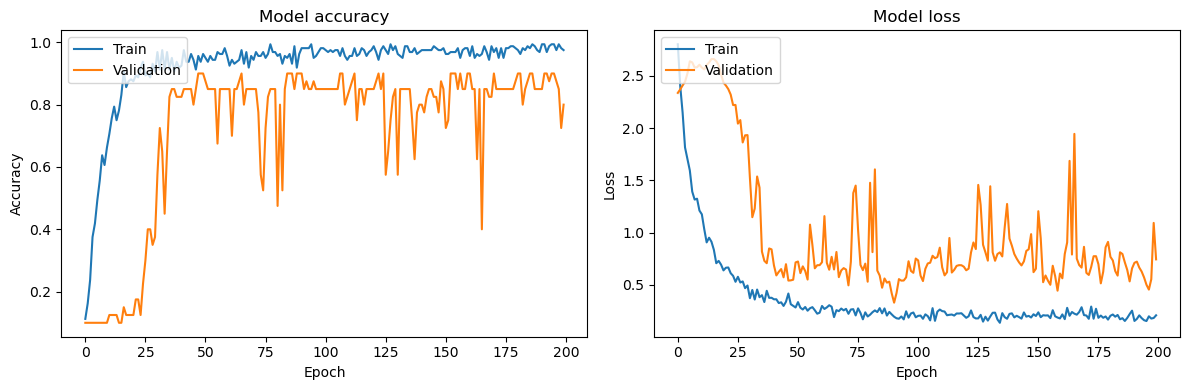

In [25]:
# Access the training history
history = model.history.history

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [31]:
def process_test_songs(test_folder):
    X_test = []
    file_names = []
    for i in range(1, 16):  # Assuming files are named test (1).wav to test (15).wav
        file_path = os.path.join(test_folder, f"test ({i}).wav")
        print("file path is: ", file_path)
        mfcc = wav2mfcc(file_path)
        X_test.append(mfcc)
        file_names.append(f"test ({i}).wav")
    return np.array(X_test), file_names

def load_ground_truth(file_path):
    with open(file_path, 'r') as f:
        return [line.strip() for line in f.readlines()]

test_folder = './Test'
X_test_songs, test_file_names = process_test_songs(test_folder)
X_test_songs = X_test_songs.reshape(X_test_songs.shape[0], X_test_songs.shape[1], X_test_songs.shape[2], 1)

ground_truth = load_ground_truth('./Test/test_groundTruth.txt')

predictions = model.predict(X_test_songs)

correct_predictions = 0
for i, prediction in enumerate(predictions):
    predicted_artist = labels[np.argmax(prediction)]
    true_artist = ground_truth[i]
    is_correct = predicted_artist == true_artist
    if is_correct:
        correct_predictions += 1
    
    print(f"File: {test_file_names[i]}")
    print(f"Predicted Artist: {predicted_artist}")
    print(f"True Artist: {true_artist}")
    print(f"Correct: {is_correct}")
    print(f"Confidence: {np.max(prediction):.2f}")
    print("---")

accuracy = correct_predictions / len(predictions)
print(f"Overall Accuracy: {accuracy:.2f}")

file path is:  ./Test\test (1).wav
file path is:  ./Test\test (2).wav
file path is:  ./Test\test (3).wav
file path is:  ./Test\test (4).wav
file path is:  ./Test\test (5).wav
file path is:  ./Test\test (6).wav
file path is:  ./Test\test (7).wav
file path is:  ./Test\test (8).wav
file path is:  ./Test\test (9).wav
file path is:  ./Test\test (10).wav
file path is:  ./Test\test (11).wav
file path is:  ./Test\test (12).wav
file path is:  ./Test\test (13).wav
file path is:  ./Test\test (14).wav
file path is:  ./Test\test (15).wav
1/1 [==============================] - 0s 21ms/step
File: test (1).wav
Predicted Artist: Eason
True Artist: Avril
Correct: False
Confidence: 0.65
---
File: test (2).wav
Predicted Artist: CheerChen
True Artist: CheerChen
Correct: True
Confidence: 0.78
---
File: test (3).wav
Predicted Artist: JJ
True Artist: BrunoMars
Correct: False
Confidence: 0.55
---
File: test (4).wav
Predicted Artist: EdSheeran
True Artist: Eason
Correct: False
Confidence: 0.43
---
File: test (5